<a href="https://colab.research.google.com/github/shauryanegi/tensorflow-deep-learning/blob/gh-pages/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We have seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 classes of Food)

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to beat the original Food101 paper's results with 10% of data.

https://link.springer.com/content/pdf/10.1007%2F978-3-319-10599-4_29.pdf

### Our baseline is to beat 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we are using a GPU.
!nvidia-smi

Mon Aug 16 12:14:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper fnctions

In previous notebooks, we created a series of helper functions to do different tasks, let us download them.

In [2]:
!pip install wget
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=182aeca57195c94002ce92572ab8cda866edf2fafb210b4a8f61a4b9829a7368
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
--2021-08-16 12:14:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-16 12:14:27 (66.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook.
from helper_functions import create_tensorboard_callback, load_and_prep_image, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so let us download it.

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original Food101 dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the Food Vision preprocessing notebook).

We download the data as a zip file so we'll use our unzip_data() function to unzip it.

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir =  "101_food_classes_10_percent/test/"

--2021-08-16 12:14:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  95.2MB/s    in 15s     

2021-08-16 12:14:45 (100 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE,
                                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning with 10% of 101 Food classes

Here are the steps we're going to take:
* A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

* Data augmentation built right into the model

* A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model

* A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

* Categorical crossentropy as the loss function since we're dealing with more than two classes

* The Adam optimizer with the default settings

* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True,
                                                         save_weights_only = True)

In [8]:
# Create Data Augmentation layer to incorporate it into the model.
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
                                preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
                                preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
                                preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
                                preprocessing.RandomZoom(0.2), # randomly zoom into an image
                                # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")
 

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")  # shape of input image
x = data_augmentation(inputs)  # augment images (only happens during training)
x = base_model(
    x, training=False
)  # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(
    x
)  # pool the outputs of the base model
outputs = layers.Dense(
    len(train_data_all_10_percent.class_names),
    activation="softmax",
    name="output_layer",
)(
    x
)  # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)


16711680/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Compile the model

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

# Fit the model

history_all_classes_10_percent = model.fit(train_data_all_10_percent, epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])
                      

Epoch 1/5
237/237 [==============================] - 167s 559ms/step - loss: 3.4566 - accuracy: 0.2471 - val_loss: 2.7067 - val_accuracy: 0.3578
Epoch 2/5
237/237 [==============================] - 106s 444ms/step - loss: 2.3488 - accuracy: 0.4565 - val_loss: 2.2631 - val_accuracy: 0.4436
Epoch 3/5
237/237 [==============================] - 102s 430ms/step - loss: 1.9831 - accuracy: 0.5327 - val_loss: 2.1269 - val_accuracy: 0.4571
Epoch 4/5
237/237 [==============================] - 96s 403ms/step - loss: 1.7582 - accuracy: 0.5773 - val_loss: 1.9801 - val_accuracy: 0.4886
Epoch 5/5
237/237 [==============================] - 90s 378ms/step - loss: 1.5960 - accuracy: 0.6074 - val_loss: 1.9148 - val_accuracy: 0.4976


In [12]:
# Summarize our Model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Evaluate on the whole dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 143s 181ms/step - loss: 1.7290 - accuracy: 0.5505


[1.729037880897522, 0.5504554510116577]

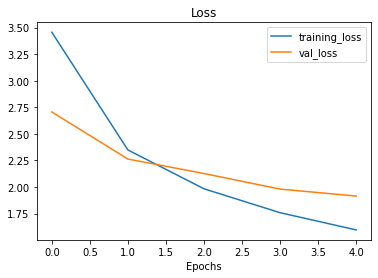

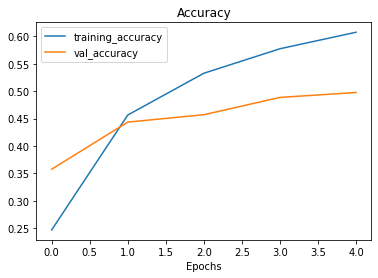

In [14]:
# Plot loss curves
plot_loss_curves(history_all_classes_10_percent)

🤔 Question: What do these curves suggest? 

Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the ModelCheckpoint callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5

for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [16]:
# Recompile our model with a lower learning rate (10x less)\

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
              metrics = ['accuracy'])

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
# Fit the model
fine_tune_epochs = 10
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                epochs = fine_tune_epochs,
                                                validation_data = test_data,
                                                validation_steps = int(0.15 * len(test_data)), # validate on 15% of test data
                                                initial_epoch = history_all_classes_10_percent.epoch[-1] # start from previous last epoch
                                                )

Epoch 5/10
237/237 [==============================] - 100s 386ms/step - loss: 1.3621 - accuracy: 0.6516 - val_loss: 1.8622 - val_accuracy: 0.5093
Epoch 6/10
237/237 [==============================] - 88s 369ms/step - loss: 1.2330 - accuracy: 0.6758 - val_loss: 1.8961 - val_accuracy: 0.5037
Epoch 7/10
237/237 [==============================] - 85s 356ms/step - loss: 1.1629 - accuracy: 0.6940 - val_loss: 1.8677 - val_accuracy: 0.5130
Epoch 8/10
237/237 [==============================] - 83s 349ms/step - loss: 1.0986 - accuracy: 0.7090 - val_loss: 1.8638 - val_accuracy: 0.5167
Epoch 9/10
237/237 [==============================] - 81s 341ms/step - loss: 1.0234 - accuracy: 0.7303 - val_loss: 1.8538 - val_accuracy: 0.5215
Epoch 10/10
237/237 [==============================] - 79s 331ms/step - loss: 0.9508 - accuracy: 0.7459 - val_loss: 1.8761 - val_accuracy: 0.5164


In [20]:
# Evaluate on whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 141s 179ms/step - loss: 1.6274 - accuracy: 0.5739


[1.6273634433746338, 0.5739405751228333]

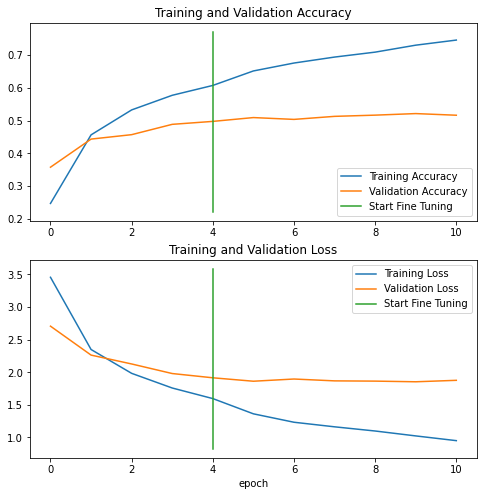

In [21]:
# Compare historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, EfficientNetB0 was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

Saving our trained model
To prevent having to retrain our model from scratch, let's save it to file using the save() method.

In [22]:
## Save model to drive so it can be used later 
model.save("drive/MyDrive/TensorFlow/101_food_classes_10_percent_saved_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/TensorFlow/101_food_classes_10_percent_saved_big_dog_model/assets


In [23]:
# Load and evalualte saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 145s 182ms/step - loss: 1.6274 - accuracy: 0.5739


In [25]:
# Results from our loaded model above
all_classes_10_percent_fine_tune_results

[1.6273634433746338, 0.5739405751228333]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and figure out which predictions were wrong.

In [26]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-16 12:47:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.3MB/s    in 2.0s    

2021-08-16 12:47:17 (22.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model( the one we downloaded on test data)
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 146s 183ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the predict() method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [33]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose = 1) # set verbosity to see how long is left

790/790 [==============================] - 87s 109ms/step


In [34]:
# How many predictions are there?
len(preds_probs)

25250

In [35]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542365e-02, 3.5742380e-06, 4.1376989e-02, ..., 1.4138919e-09,
        8.3531530e-05, 3.0897669e-03],
       [9.6401691e-01, 1.3753039e-09, 8.4780302e-04, ..., 5.4286538e-05,
        7.8363262e-12, 9.8466790e-10],
       [9.5925879e-01, 3.2534117e-05, 1.4866935e-03, ..., 7.1891890e-07,
        5.4398049e-07, 4.0276391e-05],
       ...,
       [4.7313297e-01, 1.2931194e-07, 1.4805554e-03, ..., 5.9749780e-04,
        6.6969653e-05, 2.3469136e-05],
       [4.4571746e-02, 4.7265476e-07, 1.2258559e-01, ..., 6.3498919e-06,
        7.5319153e-06, 3.6778722e-03],
       [7.2438931e-01, 1.9249764e-09, 5.2310719e-05, ..., 1.2291402e-03,
        1.5793009e-09, 9.6395699e-05]], dtype=float32)

In [37]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542365e-02, 3.5742380e-06, 4.1376989e-02, 1.0660797e-09,
        8.1614733e-09, 8.6639638e-09, 8.0925633e-07, 8.5652727e-07,
        1.9858839e-05, 8.0977213e-07, 3.1727312e-09, 9.8674104e-07,
        2.8531923e-04, 7.8049323e-10, 7.4231526e-04, 3.8916223e-05,
        6.4740229e-06, 2.4977014e-06, 3.7891594e-05, 2.0678598e-07,
        1.5538433e-05, 8.1506852e-07, 2.6230912e-06, 2.0010681e-07,
        8.3827507e-07, 5.4215407e-06, 3.7391314e-06, 1.3150807e-08,
        2.7761410e-03, 2.8052178e-05, 6.8561751e-10, 2.5574704e-05,
        1.6688925e-04, 7.6409168e-10, 4.0452890e-04, 1.3150506e-08,
        1.7957424e-06, 1.4448282e-06, 2.3062862e-02, 8.2465419e-07,
        8.5367139e-07, 1.7138558e-06, 7.0526098e-06, 1.8402373e-08,
        2.8554078e-07, 7.9483289e-06, 2.0681923e-06, 1.8525253e-07,
        3.3620211e-08, 3.1522621e-04, 1.0410861e-05, 8.5448426e-07,
        8.4741843e-01, 1.0555483e-05, 4.4094952e-07, 3.7404458e-05,
        3.5306322e-05, 3.2489061e-05, 6.7314213e

What we've got is often referred to as a predictions probability tensor (or array).

Let's see what the first 10 look like.

In [40]:
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 : {preds_probs[0].argmax()}")

Number of prediction probabilites for sample 0: 101
What prediction probability sample 0 looks like 
 [5.9542365e-02 3.5742380e-06 4.1376989e-02 1.0660797e-09 8.1614733e-09
 8.6639638e-09 8.0925633e-07 8.5652727e-07 1.9858839e-05 8.0977213e-07
 3.1727312e-09 9.8674104e-07 2.8531923e-04 7.8049323e-10 7.4231526e-04
 3.8916223e-05 6.4740229e-06 2.4977014e-06 3.7891594e-05 2.0678598e-07
 1.5538433e-05 8.1506852e-07 2.6230912e-06 2.0010681e-07 8.3827507e-07
 5.4215407e-06 3.7391314e-06 1.3150807e-08 2.7761410e-03 2.8052178e-05
 6.8561751e-10 2.5574704e-05 1.6688925e-04 7.6409168e-10 4.0452890e-04
 1.3150506e-08 1.7957424e-06 1.4448282e-06 2.3062862e-02 8.2465419e-07
 8.5367139e-07 1.7138558e-06 7.0526098e-06 1.8402373e-08 2.8554078e-07
 7.9483289e-06 2.0681923e-06 1.8525253e-07 3.3620211e-08 3.1522621e-04
 1.0410861e-05 8.5448426e-07 8.4741843e-01 1.0555483e-05 4.4094952e-07
 3.7404458e-05 3.5306322e-05 3.2489061e-05 6.7314213e-05 1.2852466e-08
 2.6220504e-10 1.0318048e-05 8.5743690e-05 1.0

In [45]:
# Get the pred class of each class
pred_classes = preds_probs.argmax(axis = 1)

# How do they look?
pred_classes [:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

### Now we have got predcitions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [47]:
# To get our test labels, we need to unravel our test_data
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluate our model's predictions

One way to check that our model's predictions array is in same order as of same test labels array is to find the accuracy score.


In [51]:
results_downloaded_model

[1.8027207851409912, 0.6077623963356018]

In [54]:
# Let us try sklearn accuracy metric
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.6077623762376237

In [55]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

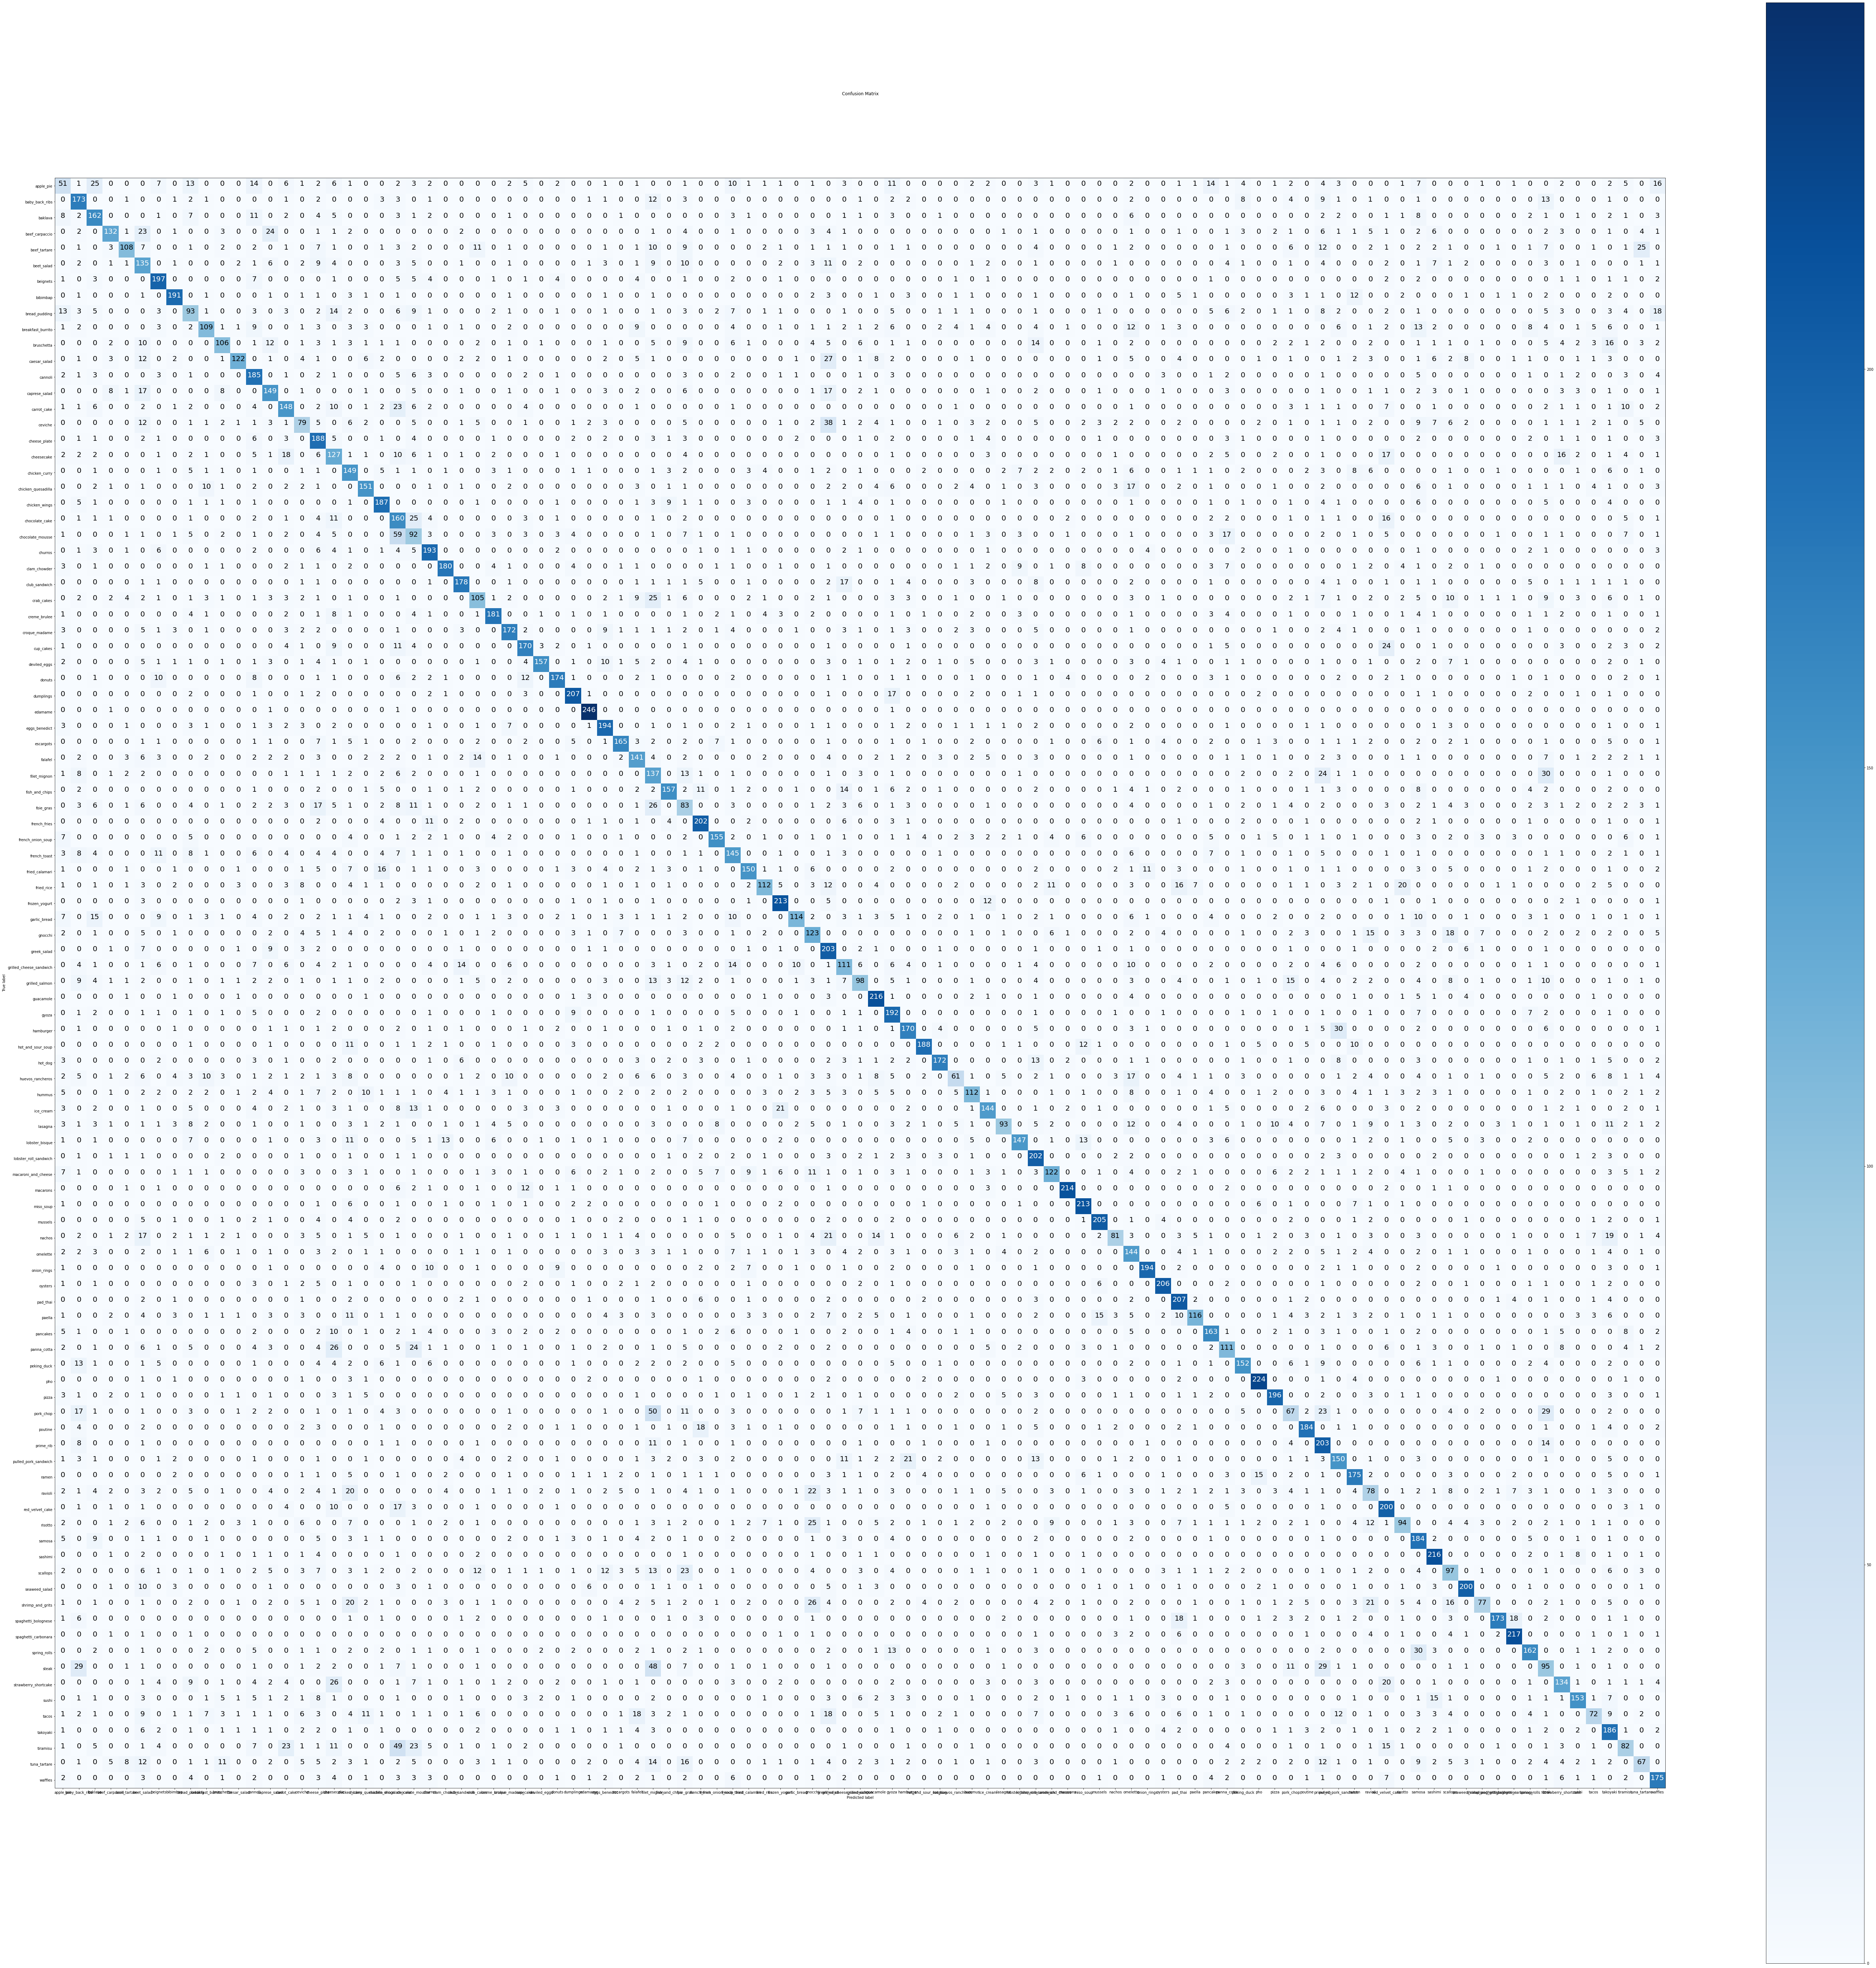

In [57]:
# Let us make a confusion matrix
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = test_data.class_names,
                      figsize = (100,100),
                      text_size = 20)

In [63]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

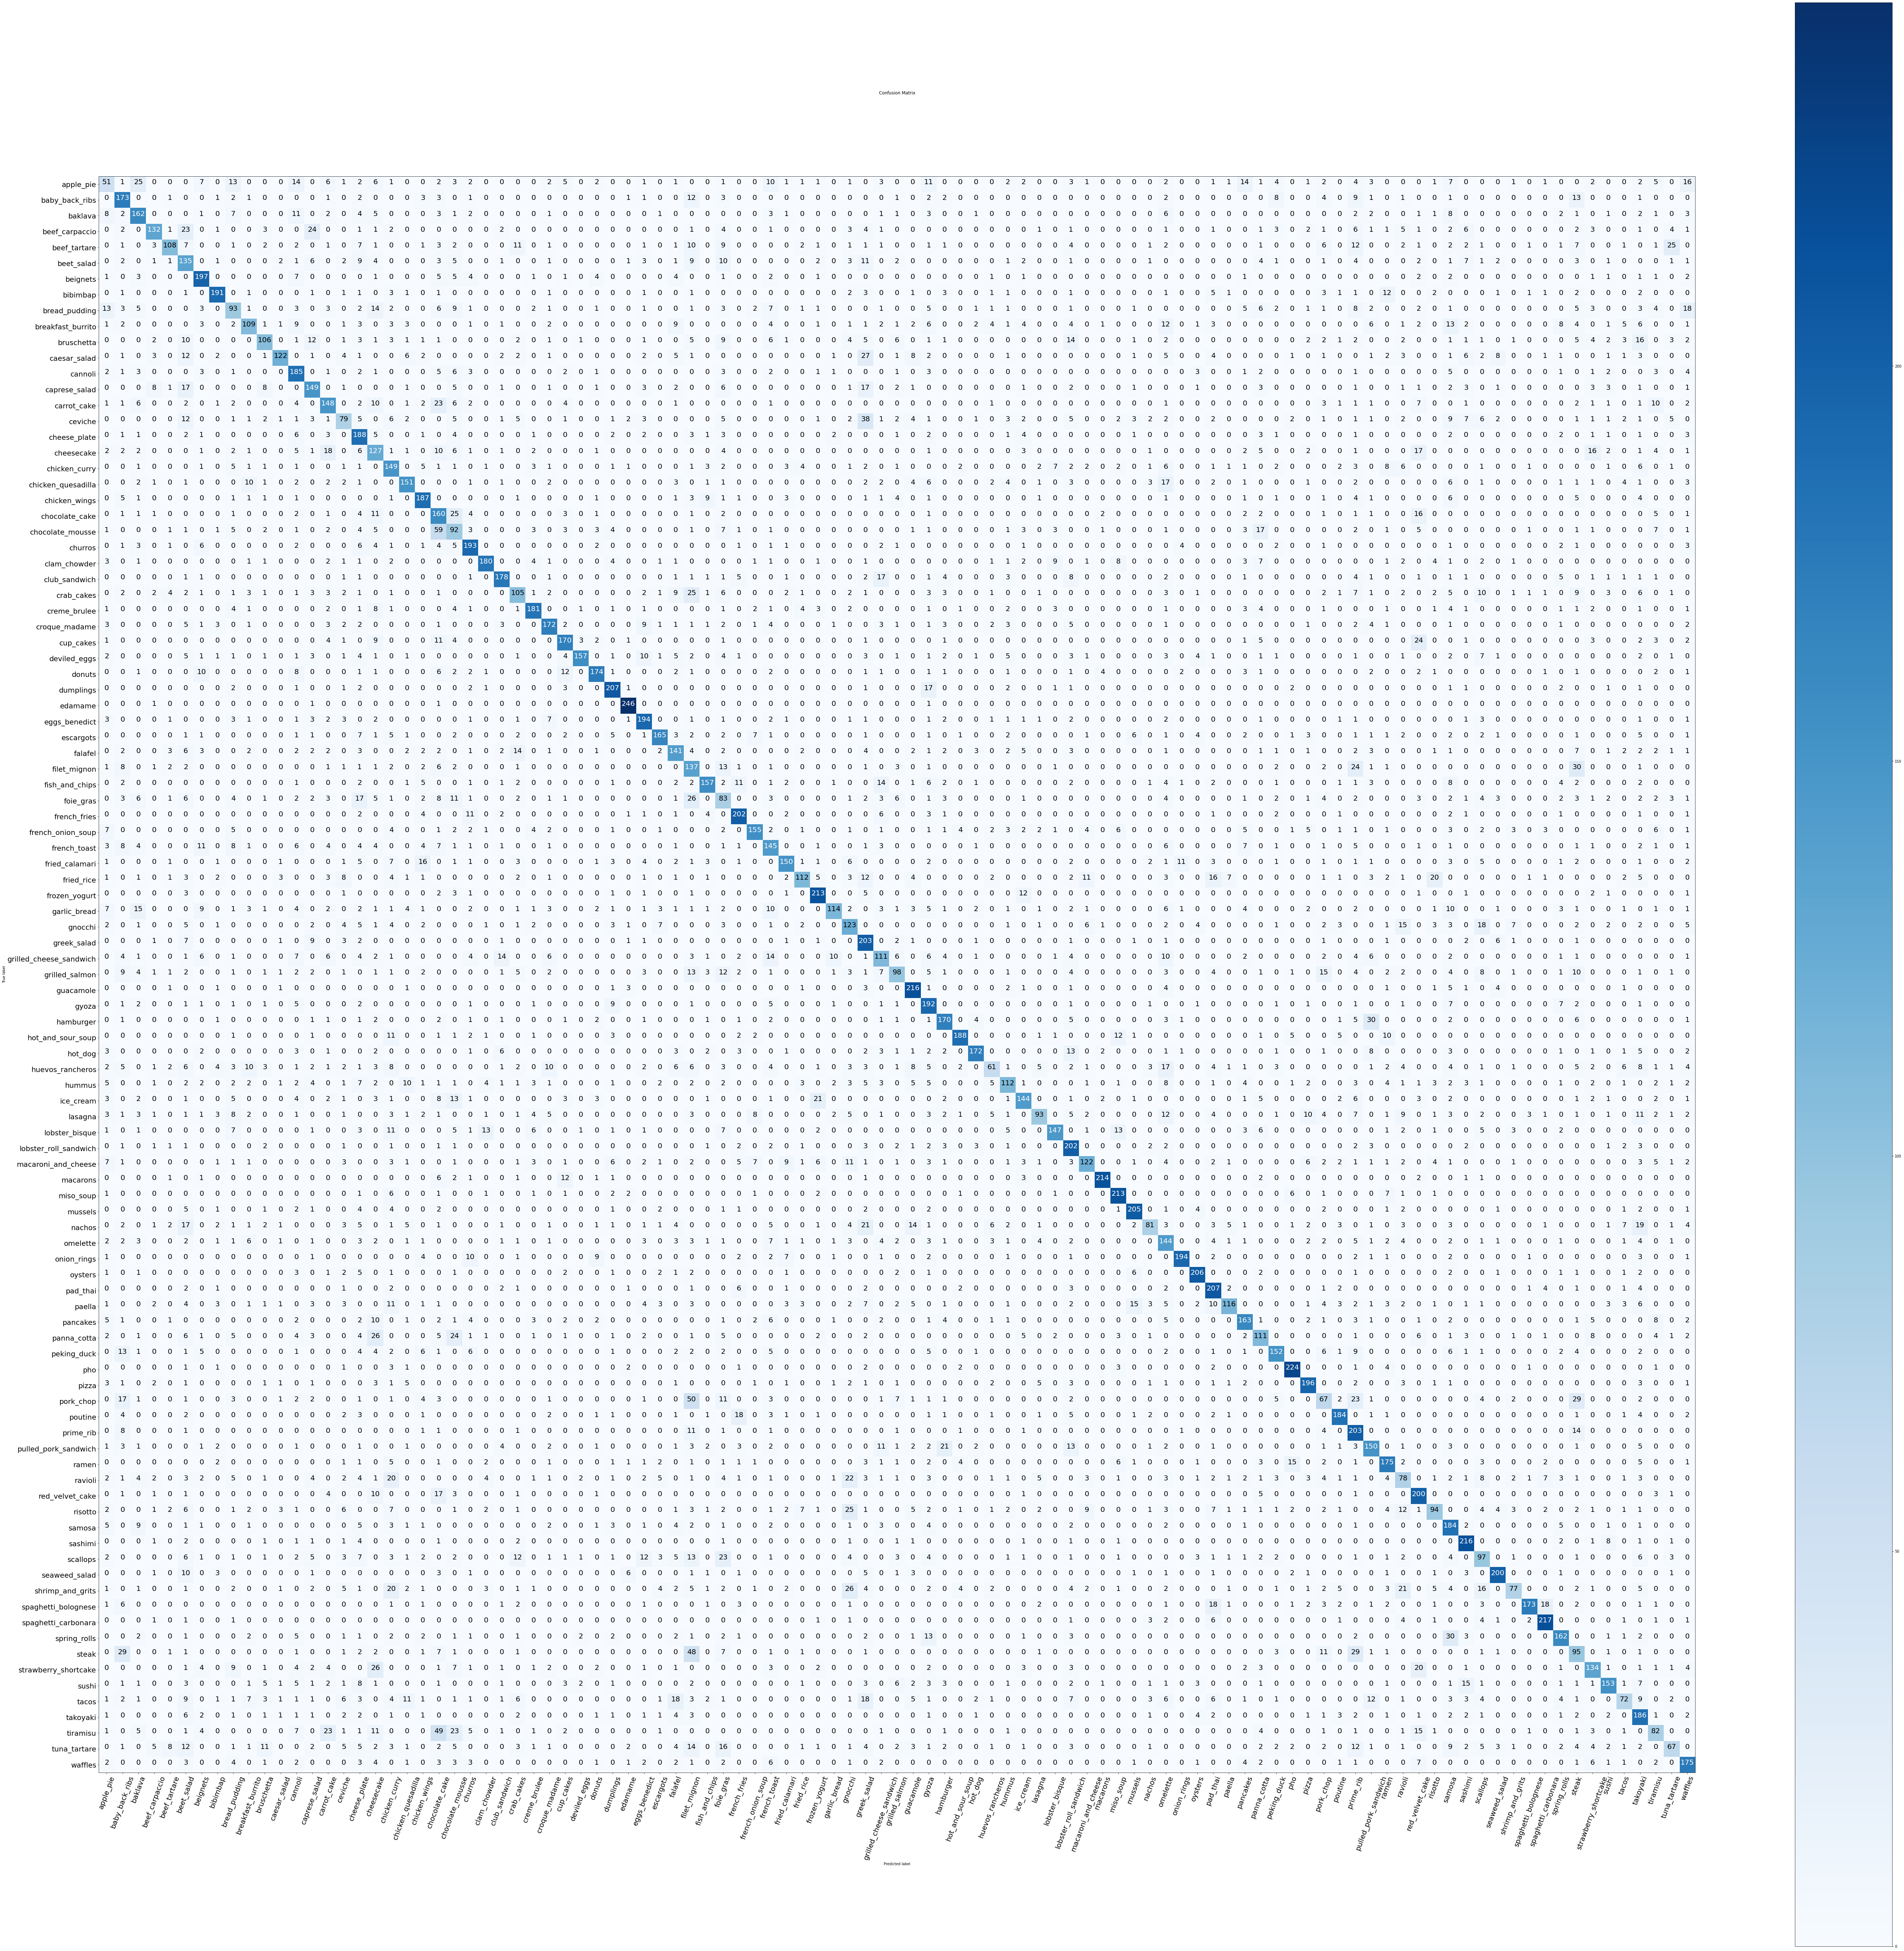

In [64]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = test_data.class_names,
                      figsize = (100,100),
                      text_size = 20)

In [65]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The classification_report() outputs the precision, recall and f1-score's per class.

A reminder:

Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).

Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). 
Higher recall leads to less false negatives.

F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst.
The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of classification_report() as a dictionary by setting output_dict=True.

In [72]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict= True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Alright, there's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called class_f1_scores and then loop through each item in classification_report_dict, appending the class name and f1-score as the key, value pairs in class_f1_scores.

In [73]:
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [74]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [89]:
# Turn f1-scores into dataframes for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names" : list(class_f1_scores.keys()),
                          "f1-scores" :list(class_f1_scores.values())}).sort_values("f1-scores", ascending = False)

In [90]:
f1_scores[:10]

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
68          onion_rings   0.832618
65              mussels   0.820000
88        seaweed_salad   0.813008
64            miso_soup   0.812977
45        frozen_yogurt   0.811429

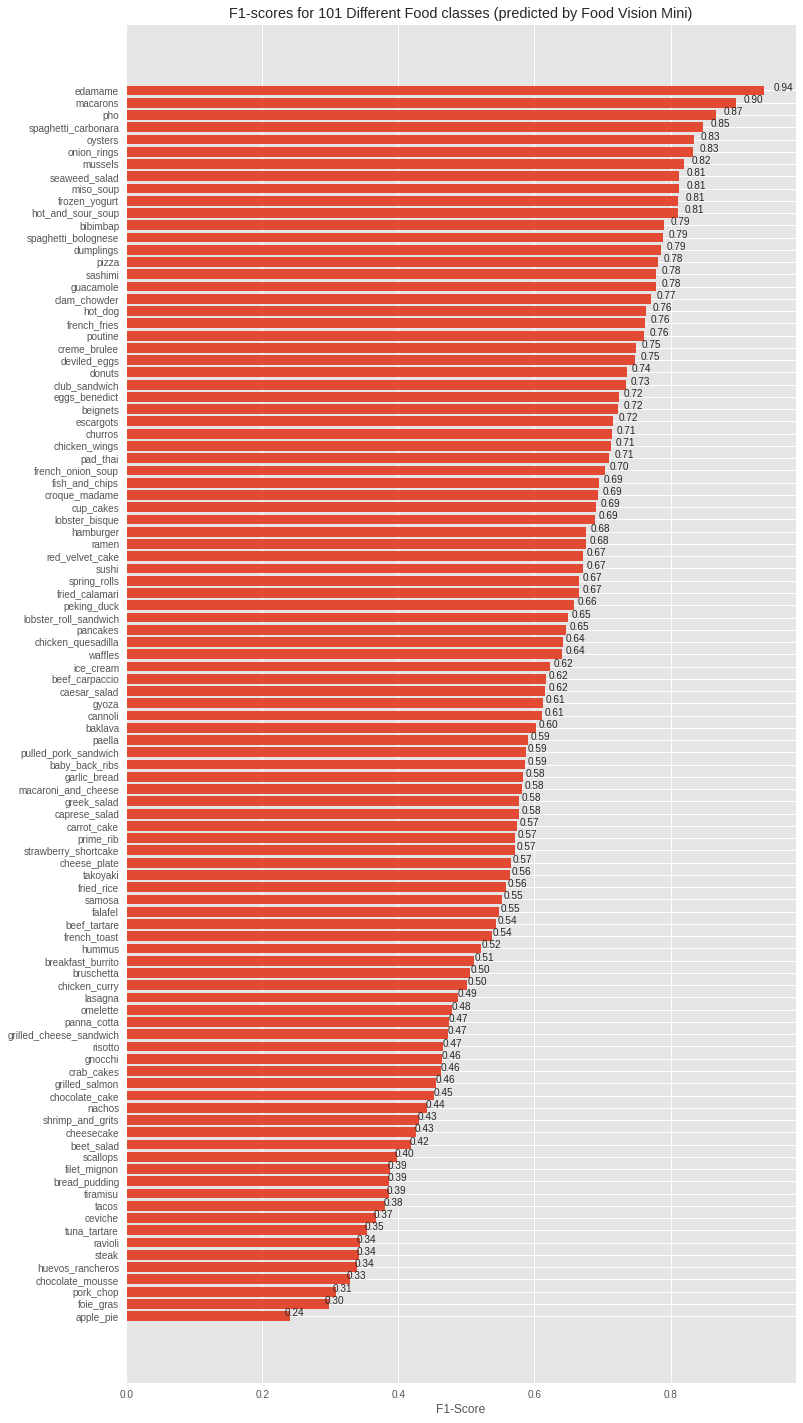

In [96]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-scores for 101 Different Food classes (predicted by Food Vision Mini)")
ax.invert_yaxis(); # Reverse the order of our plot

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like apple_pie and ravioli while for classes like edamame and pho the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

In [97]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

## Visualizing predicitions on custom images

How does our model go on with food images not in our dataset.


As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

Read in a target image filepath using tf.io.read_file().

Turn the image into a Tensor using tf.io.decode_image().

Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.
resize().

Scale the image to get all the pixel values between 0 & 1 if necessary.

In [98]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale = True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True

  """

  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to:

Load a few random images from the test dataset.

Make predictions on them.

Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

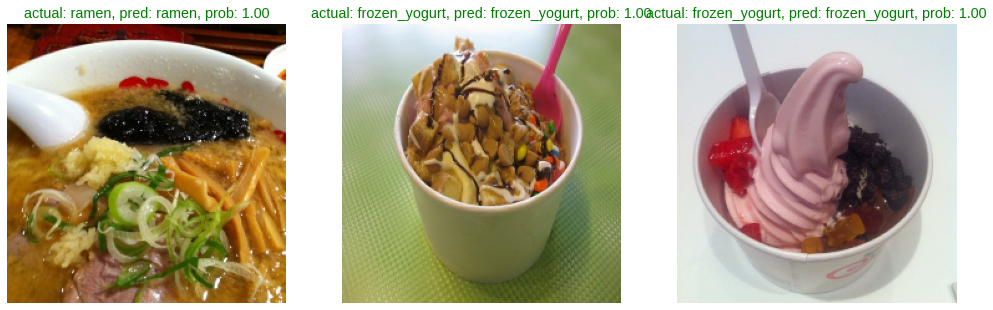

In [99]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

# Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as baby_back_ribs getting mistaken as steak and vice versa.

In [100]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

Their ground truth labels (y_labels).
The class the model predicted (pred_classes).
The maximum prediction probabilitity value (pred_probs.max(axis=1)).
The ground truth class names.
The predicted class names

In [103]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  ...      y_pred_classname
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...                 gyoza
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...             apple_pie
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...             apple_pie
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...  pulled_pork_sandwich
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...             prime_rib

[5 rows x 6 columns]

In [104]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False

[5 rows x 7 columns]

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [105]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'101_food_classes_10_percent/test/scallops/17...  ...         False
231    b'101_food_classes_10_percent/test/apple_pie/8...  ...         False
15359  b'101_food_classes_10_percent/test/lobster_rol...  ...         False
23539  b'101_food_classes_10_percent/test/strawberry_...  ...         False
21400  b'101_food_classes_10_percent/test/samosa/3140...  ...         False
24540  b'101_food_classes_10_percent/test/tiramisu/16...  ...         False
2511   b'101_food_classes_10_percent/test/bruschetta/...  ...         False
5574   b'101_food_classes_10_percent/test/chocolate_m...  ...         False
17855  b'101_food_classes_10_percent/test/paella/2314...  ...         False
23797  b'101_food_classes_10_percent/test/sushi/16593...  ...         False
18001  b'101_food_classes_10_percent/test/pancakes/10...  ...         False
11642  b'101_food_classes_10_percent/test/garlic_brea...  ...         False
10847  b'101_food_classes_10_percent/test/fried_calam...  ...         False
23631  b'101_food_classes_10_percent/test/strawberry_...  ...         False
1155   b'101_food_classes_10_percent/test/beef_tartar...  ...         False
10854  b'101_food_classes_10_percent/test/fried_calam...  ...         False
23904  b'101_food_classes_10_percent/test/sushi/33652...  ...         False
7316   b'101_food_classes_10_percent/test/cup_cakes/1...  ...         False
13144  b'101_food_classes_10_percent/test/gyoza/31214...  ...         False
10880  b'101_food_classes_10_percent/test/fried_calam...  ...         False

[20 rows x 7 columns]

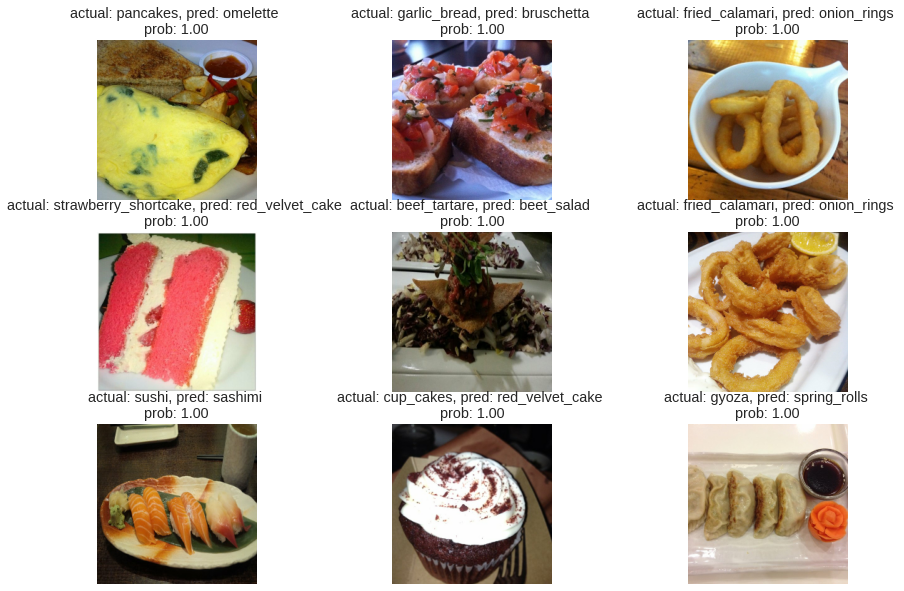

In [106]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

Some of the labels might be wrong - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as active learning.
Could more samples be collected? - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food
So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [107]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-08-16 14:05:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  28.5MB/s    in 0.4s    

2021-08-16 14:05:14 (28.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [108]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']


Now we can use similar code to what we used previously to load in our images, make a prediction on each using our trained model and then plot the image along with the predicted class.

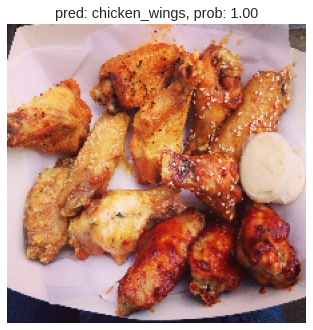

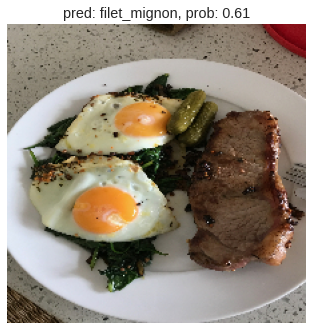

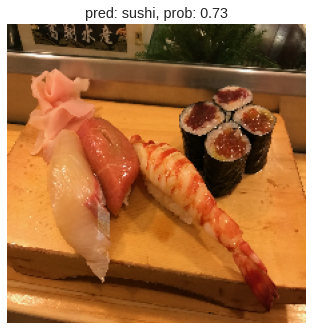

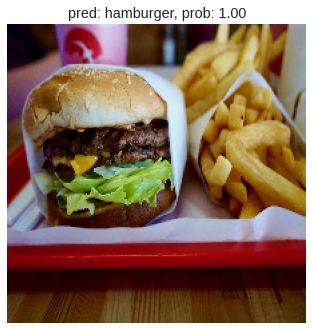

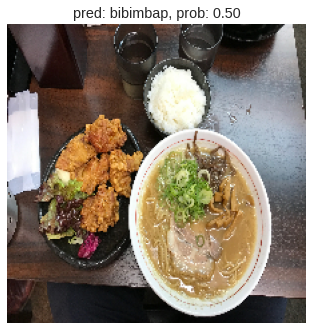

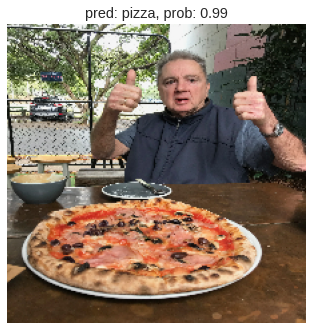

In [109]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)? Hint: that's your task in the next notebook.